<h1 style="font-size:40px;"><center>Exercise II:<br> Convolutional Neural Networks
</center></h1>

## Short summary
In this exercise you will: 

* Train CNNs for a binary classification problem
* Visualize how CNN interprets the data
* (Optional) Train a CNN to count corners in polygons

In this lab we will look at network architectures that are designed to handle specific kinds of data. Convolutional Neural Networks for image processing  

## The data
Digits "5" and "6" from the MNIST database used for a binary classification problem.

## The exercises
As for the previous lab all exercises are found below.

## The different 'Cells'
This notebook contains several cells with python code, together with the markdown cells (like this one) with only text. Each of the cells with python code has a "header" markdown cell with information about the code. The table below provides a short overview of the code cells. 

| #  |  CellName | CellType | Comment |
| :--- | :-------- | :-------- | :------- |
| 1 | Init | Needed | Sets up the environment|
| 2 | Data | Needed | Loading images for the CNN exercise |
| 3 | PlotImg | Information  | View some of the images |
| 4 | Stats | Needed | Compute classification results |
| 5 | Ex1 | Exercise | For question 1-2 |
| 6 | Ex2 | Exercise | For question 3 |


In order for you to start with the exercise you need to run all cells with the CellType "Needed". The very first time you start with this exercise we suggest that you enter each of the needed cells, read the cell instruction and run the cell. It is important that you do this in the correct order, starting from the top and work you way down the cells. Later when you have started to work with the notebook it may be easier to use the command "Run All" found in the "Cell" dropdown menu.

## Writing the report
First the report should be written within this notebook. We have prepared the last cell in this notebook for you where you should write the report. The report should contain 4 parts:

* Name:
* Introduction: A **few** sentences where you give a small introduction of what you have done in the lab.
* Answers to questions: For each of the questions provide an answer. It can be short answers or a longer ones depending on the nature of the questions, but try to be effective in your writing.
* Conclusion: Summarize your findings in a few sentences.


## Last but not least
Have fun again!




### CellName: Init (#1)
### CellType: Needed
### Cell instruction: Initializing the libraries
In the cell below, we import all the libraries that are needed for this exercises. There is one configuration parameter that you can change in this cell

* Inline or "pop out" plots.

See comments in the cell for more information. Run the cell by entering into the cell and press "CTRL Enter".


In [1]:
import numpy as np
import tensorflow as tf
import time
import os
os.environ["CUDA_VISIBLE_DEVICES"]=""

import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import TimeDistributed
from keras.layers import Lambda, concatenate
from keras.layers import LSTM, GRU, SimpleRNN, RNN

from keras.optimizers import SGD, Adam, RMSprop, Nadam
from keras import backend as K

from sklearn.metrics import *

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# To have the plots inside the notebook "inlin" should be True. 
# If "inlin" = False, then plots will pop out of the notebook
inlin = True # True/False
if inlin:
    %matplotlib inline
else:
    %matplotlib

import matplotlib
import matplotlib.pyplot as plt


Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7937318954047945687
]


### CellName: Data (#2)
### CellType: Needed
### Cell instruction: Function for getting images for the CNN exercises

This cell defines the functions that obtain the images needed for the CNN exercise.

Run the cell by entering into the cell and press "CTRL Enter".

In [2]:
def loadMNIST56():
    xtrain, ytrain, xtest, ytest = np.load("mnist56.npy")
    width, height = xtrain.shape[1:3]
    return xtrain, ytrain, xtest, ytest, width, height


### CellName: PlotImg (#3)
### CellType: Information
### Cell instruction: Show some of the images

Here we look at the first ten pictures in the training set, and their respective targets. You can select the dataset to look at by uncomment the correct line.

Run the cell by entering into the cell and press "CTRL Enter".

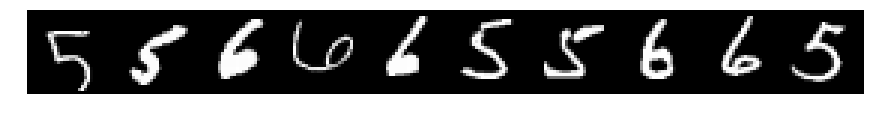

Targets:
[0. 0. 1. 1. 1. 0. 0. 1. 1. 0.]


In [3]:
xtrain, ytrain, xtest, ytest, width, height = loadMNIST56()

plt.figure(1, figsize=(15,10))
plt.imshow(xtrain[:10,:,:].swapaxes(0,1).reshape(width,10*height),cmap="gray")
plt.axis("off")
plt.show()

print("Targets:")
print(ytrain[:10])


### CellName: Stats (#4)
### CellType: Needed
### Cell instruction: Get binary and 3-class classification results

This cell just defines functions that we can call to compute som performance measures for binary and 3-class classification problems.

Run the cell by entering into the cell and press "CTRL Enter".

In [4]:
def binary_pred_stats(ytrue, ypred, threshold=0.5):
    one_correct = np.sum((ytrue==1)*(ypred > threshold))
    zero_correct = np.sum((ytrue==0)*(ypred <= threshold))
    sensitivity = one_correct / np.sum(ytrue==1)
    specificity = zero_correct / np.sum(ytrue==0)
    accuracy = (one_correct + zero_correct) / len(ytrue)
    return sensitivity, specificity, accuracy

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
def multi_stat_3(model = None, x_test = None, y_test = None, lbl = None):
    y_pred = model.predict(x_test, verbose=0 )
    print(lbl,' log_loss:  ', log_loss(y_test, y_pred, eps=1e-15))

    y_true = y_test.argmax(axis=1)
    y_pred = y_pred.argmax(axis=1)
    print(lbl, ' accuracy:  ',(y_pred==y_true).mean(), '\n')

    target_names = ['class {}'.format(i+1) for i in range(3)]

    confuTst = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm           = confuTst, 
                          normalize    = False,
                          target_names = target_names,
                          title        = "Confusion Matrix: " + lbl)


### CellName: Ex1 (#5)
### CellType: Exercise
### Cell instruction: Instructions for question 1-2

## CNN for image classification

In this first exercise you are going to train a CNN that can separate between numbers "5" and "6" from the mnist dataset (mnist56 dataset). We are going to use 2000 training images and 1850 test images. To start with we have a proposed CNN that can solve this problem. It consists of the following:
* First convolutional layer consisting of 4 kernels of size 3x3, with ReLU activation
* Maxpooling of size 2x2
* Second convolutional layer of 4 kernels of size 3x3, with ReLU activation
* Maxpooling of size 2x2
* Special layer *Flatten()*, just transforms the all of the max pooled filter outputs to a linear vector of outputs
* *Dense* layer, meaning a fully connected MLP like layer with 10 nodes, again ReLU activation
* Final output layer consisting of one single output node with sigmoid activation function because we have a binary classification problem.

The default is to use *stride* = 1 and no *padding* for the convolutional operation. 

#### Question 1
Make sure you understand the definition of the CNN model in the cell below and train it. **What is your test set performance in terms of the accuracy?**

#### Question 2
This image classification problem should be relatively easy since a "5" has some distict differences from a "6". Experiment with the architecture of the CNN model and try to make it smaller, but with the same almost perfect test accuracy. **How many parameters do you have in your trimmed model and state your architecture?**

**Hint:** There is of course very many ways you can make a smaller architecture. You do not need to test all of them!


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 4)         40        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 4)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 4)         148       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 4)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total para

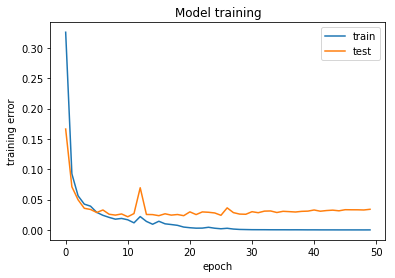

train set: 1.0 1.0 1.0
test set:  0.9906054279749478 0.9955156950672646 0.9929729729729729


In [5]:
# Load the dataset, MNIST-56
xtrain, ytrain, xtest, ytest, width, height = loadMNIST56()

# The size of the images
input_shape = (width, height, 1)

# Define the CNN model
model = Sequential()

# First conv layer
model.add(Conv2D(4, kernel_size=(3, 3), strides=1, activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

# Second conv layer
model.add(Conv2D(4, kernel_size=(3, 3), strides=1, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

# Fully connected MLP layers
model.add(Flatten())
model.add(Dense(10, activation='relu'))
#model.add(Dropout(0.5))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# We use cross entropy error and the adam optimizer
adam = Adam(lr=0.005)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

# Now train the model
estimator = model.fit(xtrain, ytrain, 
                      validation_data=(xtest, ytest),
                      epochs=50, 
                      batch_size=50,
                      verbose=0)

# Plot the training error
plt.plot(estimator.history['loss'])
plt.plot(estimator.history['val_loss'])
plt.title('Model training')
plt.ylabel('training error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc=0)
plt.show()

# Get the training predictions and results for those
predtrain = model.predict(xtrain)[:,0]
sensitivity, specificity, accuracy = binary_pred_stats(ytrain, predtrain)
print("train set:", sensitivity, specificity, accuracy)

# Get the test predictions and the results for those
predtest = model.predict(xtest)[:,0]
sensitivity, specificity, accuracy = binary_pred_stats(ytest, predtest)
print("test set: ", sensitivity, specificity, accuracy)


### CellName: Ex2 (#6)
### CellType: Exercise
### Cell instruction: Instructions for question 3

You are now going to take a look into the CNN model. There are many attempts to visualize how the CNN model is making classifications. We will here just look at the different filter outputs given an input image. So the code in the cell below will do the following:
* Select an image
* Make a forward pass through the CNN remembering all intermediate values.
* Plot all of the filters for each of the layers.
* One can select to plot before or after the MaxPooling.

This cell relies on the fact that you have run the cell above (Ex1) so that test data has been defined and you have a trained model.

#### Question 3
Train a CNN for the "5" vs "6" problem! As a suggestion use the following CNN

*3x(3x3 kernel)-maxpool-3x(3x3 kernel)-maxpool-(Flatten)-Dense(5)-Dense(1)*

Make sure that your trained model gives good test results (i.e. > 95% accuracy). Having such a model, you can run the cell below. There are two parameters in the cell, *post_pool* or *idx*. The post_pool variable can be set to *True* meaning that filters will be shown after MaxPooling. The image to show is selected by the *idx* variable. As an example, the following values represent,
* idx=1 number "6"
* idx=2 numner "5"
* idx=3 another number "6"
* idx=5 antoher number "5"

**Can you find some property in the filters that makes sense when it comes to separating "5" from "6"?**

Hint! If you repeat the training you may get new filters!


1.0


<Figure size 1296x864 with 0 Axes>

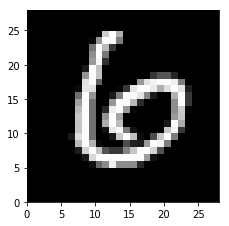

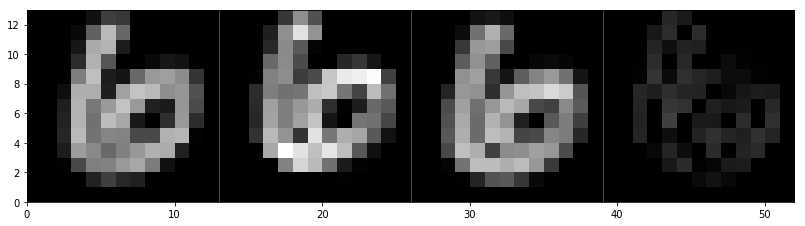

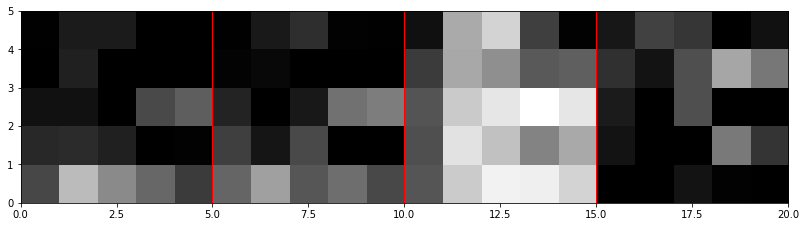

In [6]:
# if True then Maxpooling will be applied before showing the filter
post_pool = True

# The image index to show
idx = 1

kind = MaxPooling2D if post_pool else Conv2D
outs = [l.output for l in model.layers if isinstance(l, kind)]
#outs = [model.layers[0].input] + [l.output for l in model.layers if isinstance(l, kind)]
intermediate = K.function([model.layers[0].input, K.learning_phase()], outs)
print(ytest[idx])
states = [xtest[idx:idx+1]] + intermediate([xtest[idx:idx+1], 0])
#states = intermediate([xtest[idx:idx+1], 0])
plt.figure(figsize=(18,12))                    
for k,s in enumerate(states):
    plt.figure(figsize=(18,12))
    plt.subplot(len(outs)+1,1,k+1)
    #plt.subplot(len(outs),1,k+1)
    pics = s[0]
    pics = np.rollaxis(pics,2,0)
    rows = 2 if pics.shape[0] > 8 else 1
    cols = pics.shape[0]//rows
    imgshape = pics.shape[1:]
    pics = pics.reshape((rows,cols)+imgshape)
    pics = pics.swapaxes(1,2)
    pics = pics.reshape((pics.shape[0]*pics.shape[1], pics.shape[2]*pics.shape[3]))
    extent = (0,cols*imgshape[0], 0,rows*imgshape[1])
    plt.imshow(pics,cmap='gray',extent=extent)
    for r in range(1,rows):
        plt.plot([0,cols*imgshape[0]], [r*imgshape[1], r*imgshape[1]], color='r', linestyle='-', linewidth=1)
    for c in range(1,cols):
        plt.plot([c*imgshape[0], c*imgshape[0]], [0,rows*imgshape[1]], color='r', linestyle='-', linewidth=1)



# The report!


### Name

### Introduction

### Answers to questions

### Summary
  